In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.collections
from scipy.interpolate import interp1d
sns.set()
from results import load
from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colorbar
from functions import *
#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}
experiment_phase_labels = [*experiment_phase]

#avoid Font-problem in plots for ACM/IEEE papers
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/b/projects/SACBench/functions.py:15: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from mpl_toolkits.axes_grid1.colorbar import colorbar


# Reading the results

In [2]:
#config
experiment_name = "acr"
all = None

all_new = load("acr", ["aws","gcf","ibm","azure"],["0,0,1","0,0,0.5","60,60,1","60,60,0.5","60,60,0"],3,True)
all_old = load("full", ["aws","gcf","ibm","azure"],["0,0,1","0,0,0.5","60,60,1","60,60,0.5","60,60,0"],2,True)
all_new_maf = load("low", ["azure"],["0,0,1","5,5,0","15,15,0","60,60,0"],2,True)

all = pd.concat([all_new,all_old,all_new_maf],ignore_index=True)
#this is important for phase based plots (leave it otherwise)
all = all[(all["Phase"] != "none")]
providers = all["Provider"].unique()
num_repetitions = 3
configs = all["WL"].unique()

### Styles and Constants

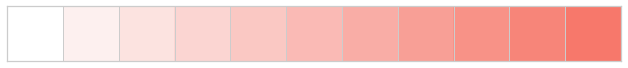

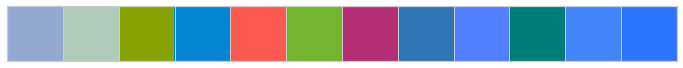

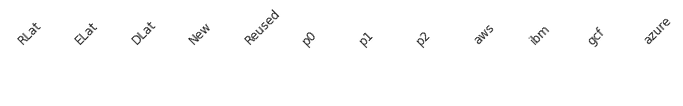

In [26]:
#sns.set_palette(sns.color_palette("Paired"))

palette = sns.color_palette().as_hex()
style = {
    "aws":{
        "name":"AWS",
        "color":"#527fff"#palette[8]
    },
    "ibm":{
        "name":"IBM",
        "color":"#007d79"#palette[1]
    },
    "gcf":{
        "name":"Google",
        "color":"#4485f9"#palette[2]
    },
    "azure":{
        "name":"MAF",
        "color":"#2d75fe" ##fec21f palette[4]
    },
    "CNew":{
        "New":"#0485d1",
        "Cold":"#0485d1",
        "Reused": "#fc5a50",
        "Warm": "#fc5a50"
    },
    #colors
    "Lats":{
        "Delivery Latency":"#d1ffbd",
        "Request-Response Latency":"#92a8d1",
        "Execution Latency":"#B1cbbb",
        "Backward Response Delivery Latency":"#89a203",
        "Delivery":"#89a203",
        "Delivery Latency":"#89a203",
        "Request-Response":"#92a8d1",
        "Execution":"#B1cbbb",
        "Backward Response Delivery":"#89a203",
        "DLat":"#89a203",
        "BLat":"#89a203",
        "RLat":"#92a8d1",
        "ELat":"#B1cbbb",
        "Failiur":"#DC1E1E"
    },
    "Phases":{
        "p0":"#74B52F",
        "p2":"#2F74B5",
        "p1":"#B52F74",
        "warmup":"#74B52F",
        "cooldown":"#2F74B5",
        "scaling":"#B52F74"
    },
    #Strings
    "Names":{
        "DLat":"Delivery Latency",
        "RLat":"Request-Response Latency",
        "ELat":"Execution Latency",
        "BLat":"Backward Response Delivery Latency",
        "p0":"warmup",
        "p1":"scaling",
        "p2":"cooldown",
        "HId":"VM",
        "CId":"Container",
        "HIdOld":"VM (old method)",
        "full":"2019",
        "acr":"2020",
        "low":"Reproduction",
        "WL":"Workload",
        "Provider":"Provider",
        "Phase":"Phase",
        "run":"Iteration",
    },
    "Workloads":{
        '0,0,1':"WL1",
        '0,0,0.5':"WL0",
        '60,60,1':"WL4",
        '60,60,0.5':"WL3",
        '60,60,0':"WL5",
        '5,5,0':"WL6",
        '15,15,0':"WL7",
        '0,0,2':"WL2"
    }
    
}

hmcmp = [(1,1,1,1),(0.996,0.945,0.941,1),(0.992,0.894,0.882,1),(0.988,0.839,0.824,1),(0.984,0.788,0.765,1),(0.984,0.733,0.710,1),(0.980,0.682,0.651,1),(0.976,0.627,0.592,1),(0.973,0.576,0.533,1),(0.969,0.522,0.475,1),(0.969,0.471,0.42,1),]

sns.set(style="whitegrid")
plotStyle(style,hmcmp)

# Masterplot V4

In [4]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
all_280 = all[all["EStart"].isna() | all["EStart"] < 280000 ]
all_280 = all_280[all_280["run"]==1]
#Latency Limits
default = [0,30]
ylims = {
    "aws":
    {"0,0,0.5":[0,3],"0,0,1":[0,6],"60,60,0.5":[0,6],"60,60,1":[0,6],"60,60,0":[0,6]},
    "ibm":
    {"0,0,0.5":default,"0,0,1":default,"60,60,0.5":default,"60,60,1":default,"60,60,0":default},
    "azure":
    {"0,0,0.5":default,"0,0,1":[0,40],"60,60,0.5":default,"60,60,1":default,"60,60,0":default,"5,5,0":default,"15,15,0":default},
    "gcf":
    {"0,0,0.5":default,"0,0,1":default,"60,60,0.5":default,"60,60,1":default,"60,60,0":default},
    "workload":
    {"0,0,0.5":[0,120],"0,0,1":[0,120],"60,60,0.5":[0,120],"60,60,1":[0,120],"60,60,0":[0,120],"5,5,0":[0,120],"15,15,0":[0,120]},
}
#Heatmap obergrenze
vmax=15
#Heatmap VM-cutoff (VMs mit weniger als x [%] auslastung  ) Reduziert verticale dichte und rechenzeit
cutoff=0.1

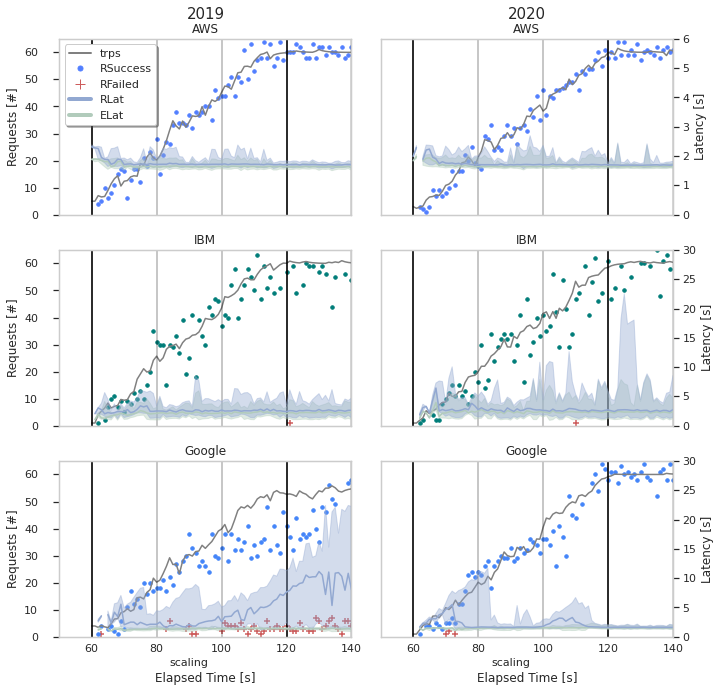

In [63]:
#setup figure
fig = plt.figure(figsize=(11,11))
gs = fig.add_gridspec(ncols=2, nrows=3,hspace=0.20,wspace=0.1)
xlim=[50,140]    
workload="0,0,1"

#plot 2019
exp="full"
provider="aws"
frame=gs[1,1]
def plot(data,exp,provider,frame,hide=True):
    data = all_280[all_280["Experiment"]==exp]
    ax = fig.add_subplot(frame)

    ax,ax2 = plotClientSideOverview(ax,data,provider,workload,style=style,ylim=ylims[provider][workload],
                           xlim=xlim,with_thruput=True,legend=False,
                           title="{}".format(style[provider]["name"]))
    ax.set_ylim([0,65])
    ax.set_xlim(xlim)
    if not hide:
        ax.set_ylabel("")
        ax.set_yticklabels([])
        ax.set_yticks([])
    else:
        ax2.set_ylabel("")
        ax2.set_yticklabels([])
        ax2.set_yticks([])
    
    return ax

ax = plot(data,"full","aws",gs[0,0])
plot(data,"full","ibm",gs[1,0])
plot(data,"full","gcf",gs[2,0])

plot(data,"acr","aws",gs[0,1],False)
plot(data,"acr","ibm",gs[1,1],False)
plot(data,"acr","gcf",gs[2,1],False)

plt.figtext(0.31,0.92, "2019", ha="center", va="top", fontsize=15)
plt.figtext(0.715,0.92, "2020", ha="center", va="top", fontsize=15)


# exp = experiment[0]
# data = all_280[all_280["Experiment"]==exp]
# ax = fig.add_subplot(gs[1])
# plotClientSideOverview(ax,data,provider,workload,style=style,ylim=ylims[provider][workload],
#                        xlim=xlim,with_thruput=True,legend=False,
#                        title="{}".format(style["Names"][exp]))
# ax.set_ylim(ylims["workload"][workload])

# exp = experiment[1]
# data = all_280[all_280["Experiment"]==exp]
# ax = fig.add_subplot(gs[0])
# plotClientSideOverview(ax,data,provider,workload,style=style,ylim=ylims[provider][workload],
#                        xlim=xlim,with_thruput=True,legend=False,
#                        title="{}".format(style["Names"][exp]))
# #fix y-axis
# ax.set_ylim(ylims["workload"][workload])

#create legend by hand
legendShapes = [
                Line2D([0], [0], color="gray", lw=2),
                Line2D([0], [0], marker='.',color=style[provider]["color"], lw=0, markersize=10),
                Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                Line2D([0], [0], color=style["Lats"]["RLat"], lw=4),
                Line2D([0], [0], color=style["Lats"]["ELat"], lw=4),
            ]
legendNames = ["trps","RSuccess","RFailed","RLat","ELat"]
ax.legend(legendShapes, legendNames, loc='upper left',fancybox=True, shadow=True, ncol=1)


plt.savefig("acr_kudos.png", bbox_inches='tight')

In [5]:
def diffPlot(data_280,workload,provider,fname,experiment=("acr","full")):       
    #setup figure
    fig = plt.figure(figsize=(11,11))
    gs = fig.add_gridspec(ncols=1, nrows=2,hspace=0.20)
    xlim=[0,280]    
   
    
    exp = experiment[0]
    data = all_280[all_280["Experiment"]==exp]
    ax = fig.add_subplot(gs[1])
    plotClientSideOverview(ax,data,provider,workload,style=style,ylim=ylims[provider][workload],
                           xlim=xlim,with_thruput=True,legend=False,
                           title="{}".format(style["Names"][exp]))
    ax.set_ylim(ylims["workload"][workload])
    
    exp = experiment[1]
    data = all_280[all_280["Experiment"]==exp]
    ax = fig.add_subplot(gs[0])
    plotClientSideOverview(ax,data,provider,workload,style=style,ylim=ylims[provider][workload],
                           xlim=xlim,with_thruput=True,legend=False,
                           title="{}".format(style["Names"][exp]))
    #fix y-axis
    ax.set_ylim(ylims["workload"][workload])
    
    #create legend by hand
    legendShapes = [
                    Line2D([0], [0], color="gray", lw=2),
                    Line2D([0], [0], marker='.',color=style[provider]["color"], lw=0, markersize=10),
                    Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                    Line2D([0], [0], color=style["Lats"]["RLat"], lw=4),
                    Line2D([0], [0], color=style["Lats"]["ELat"], lw=4),
                ]
    legendNames = ["trps","RSuccess","RFailed","RLat","ELat"]
    ax.legend(legendShapes, legendNames, loc='upper left',fancybox=True, shadow=True, ncol=2)
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')

## Paper Plots

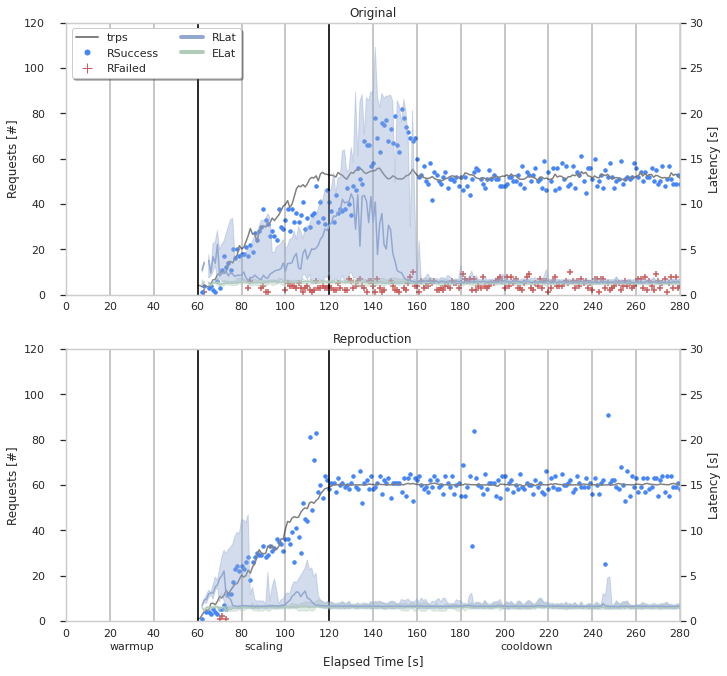

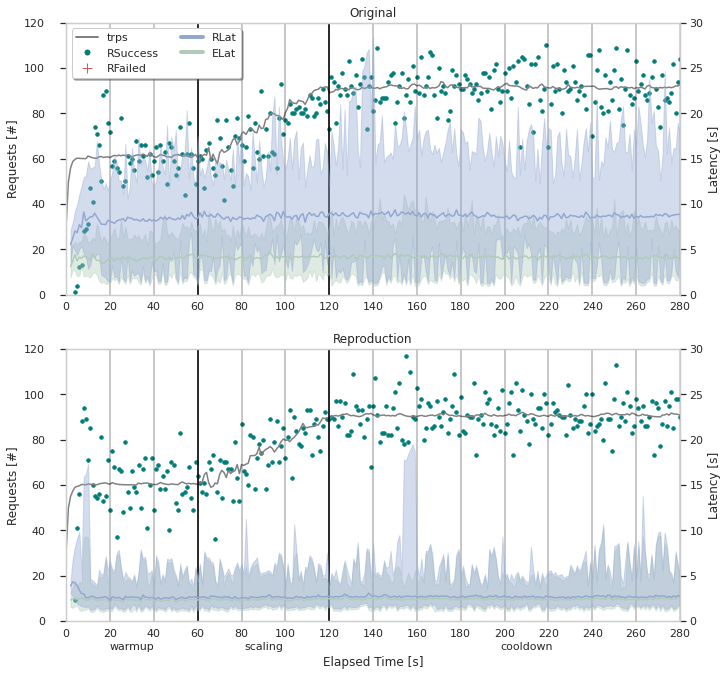

In [7]:

diffPlot(all[all["run"]==1],"0,0,1","gcf","plots/gcf.pdf",experiment=("acr","full"))
diffPlot(all,"60,60,0.5","ibm","plots/icf_60,60,0.5.pdf",experiment=("acr","full"))

## Table

In [15]:
def q(x,name):
    def _q(n):
        return np.percentile(n,x)
    _q.__name__ = name
    return _q

def count(n):
    return len(n)

def count_failed(n):
    return np.count_nonzero(n)
def percentage(n):
    return count_failed(n)/count(n)


#caution overly complicated magic function... is supposed to rename the index to the paper names ;)
#assumtion first to colums are provider and workload 
def reindex(df):
    values = df.index.values
    names = df.index.names
    new_values = []
    multidimensional = True
    for value in values:
        if type(value) is tuple:
            new_value = []
            new_value.append(style[value[0]]['name'])
            new_value.append(style["Workloads"][value[1]])
            for i in range(2,len(value)):
                new_value.append(value[i])
                
            new_values.append(tuple(new_value))
        else:
            multidimensional = False
            new_values.append(style[value]['name'])
    new_names = []
    for name in names:
        new_names.append(style["Names"][name])
        
    #print(df.index,new_values,new_names)
    if multidimensional:
        df.index=pd.MultiIndex.from_tuples(new_values,names=new_names)
    else:
        df.index=pd.Index(new_values,name=new_names[0])
    return df

count.__name__ = "Requests"
count_failed.__name__="Failed Requests"
percentage.__name__="Failed [%]"

def paperDataSet(data,providers,workloads,runs):
    data = data[data["Provider"].isin(providers)]
    data = data[data["WL"].isin(workloads)]
    data = data[data["run"].isin(runs)]
    return data

def createMetrics(data,providers,workloads,runs,group_key=["Provider","WL"],withMedian=False):
    #filter data
    data = paperDataSet(data,providers,workloads,runs)
    return metcisFromData(data,group_key,withMedian)
    
def metcisFromData(data,group_key=["Provider","WL"],withMedian=False):
    metrics = [np.mean,q(90,"p90"),q(99,"p99"),np.max]
    if withMedian:
        metrics.append(np.median)
    
    #create performance metrics
    perf = data[data["RFailed"]==False].groupby(group_key)[["RLat","ELat"]].agg(
        metrics
    )

    reliability = data.groupby(group_key)["RFailed"].agg([count,count_failed,percentage])
    
    reliability.columns = pd.MultiIndex.from_tuples([
        ('Requests','Send [\#]'),('Requests','Failed [\#]'),('Requests','Failed [\%]')
    ])
    data["ECost"] = data["ECost"]/10
    costs = data[data["RFailed"]==False].groupby(group_key)["ECost"].agg([np.mean])#,np.median])
    costs.columns = pd.MultiIndex.from_tuples([
        ('ECost [$\mu\$$]','Mean')#,('ECost [$\mu\$$]','Median'),
    ])
    
    labels = ["Mean",'90-p','99-p','Max']
    if withMedian:
        labels.append("Med")
    #python magic incoming: create a list of paired lables (latname + metric...)
    rlats = list(map(tuple,zip(["RLat"+' [s]']*len(labels),labels)))
    elats = list(map(tuple,zip(["ELat"+' [s]']*len(labels),labels)))
    #python magic over
    perf.columns = pd.MultiIndex.from_tuples(rlats+elats)
    
    
    
    reindex(perf)
    reindex(reliability)
    reindex(costs)
    
    return perf,reliability,costs

## Delta Table ICF,AWS,GCF for WL1-4

In [9]:
p_old,r_old,c_old = createMetrics(all_old,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])
p_new,r_new,c_new = createMetrics(all_new,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])

#generate diff
perf = p_new-p_old
reliability = r_new-r_old
cost = c_new-c_old
#remove Failed [%] as it makes no sense in this context
reliability = reliability.drop('Failed [\%]', axis=1, level=1)
#rename col.
reliability.columns = pd.MultiIndex.from_tuples([
        ('Requests [\#]','Send'),('Requests [\#]','Failed')
    ])

df = pd.concat([reliability,perf,cost],axis=1)
df.index = df.index.rename([""," "])

pd.options.display.float_format = "{:,.2f}".format
with open('plots/diff.tex', 'w') as f:
    f.write(df.to_latex(multicolumn_format="c",escape=False))
df

Requests [\#]        RLat [s]                     ELat [s]        \
                 Send Failed     Mean  90-p   99-p    Max     Mean  90-p   
                                                                           
AWS WL0            27      0    -0.01 -0.00   0.02   0.29     0.01  0.02   
    WL1            32      0    -0.02 -0.01   0.14   0.35     0.00  0.00   
    WL3          -242      0    -0.00  0.00   0.26   3.54    -0.00  0.00   
    WL4          -265  -2642    -0.00  0.01   0.30   0.27    -0.01 -0.01   
GCF WL0            69      0    -0.35 -0.91  -8.32 -13.08     0.11  0.04   
    WL1          1662   -869    -1.20 -6.30 -11.77 -15.60     0.18  0.11   
    WL3          -246      0    -0.12 -0.02  -5.52 -10.52     0.04  0.01   
    WL4          -273  -2610     0.14  0.17   0.04  -0.53     0.12  0.09   
ICF WL0            35      0     0.24  0.59   1.13  -9.69     0.28  0.58   
    WL1            22      0     0.15  0.28   1.74  13.92     0.19  0.30   
    WL3          -260      0    -6.00 -7.70  -9.85  -8.99    -1.74 -2.47   
    WL4          -291   2442    -6.38 -8.48 -11.67 -18.38    -1.85 -2.67   

                    ECost [$\mu\$$]  
         99-p   Max            Mean  
                                     
AWS WL0 -0.03 -0.34            0.11  
    WL1  0.05  0.38           -0.00  
    WL3 -0.02  0.54           -0.09  
    WL4  0.11  0.39           -0.10  
GCF WL0  0.12 -0.25            1.81  
    WL1  0.26  0.54            3.02  
    WL3 -0.07  0.10            0.77  
    WL4  0.21  0.25            1.92  
ICF WL0  1.02  1.04            4.78  
    WL1  1.61  4.53            3.21  
    WL3 -2.57 -0.61          -29.59  
    WL4 -3.30 -5.68          -31.42

### Repoduction Results Aggregated

In [10]:
p_new,r_new,c_new = createMetrics(all_new,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1],["Provider"],True)
#Failiur Global
pd.options.display.float_format = "{:,.4f}".format
pd.concat([r_new,p_new,c_new],axis=1)

Requests                         RLat [s]                        \
         Send [\#] Failed [\#] Failed [\%]     Mean   90-p   99-p     Max   
Provider                                                                    
AWS          74519           0      0.0000   1.7121 1.7680 2.1610  5.9180   
GCF          74440           4      0.0001   1.6058 1.7580 2.5143 11.7020   
ICF          74512        2464      0.0331   2.7568 3.5280 5.7095 22.5210   

                ELat [s]                              ECost [$\mu\$$]  
            Med     Mean   90-p   99-p     Max    Med            Mean  
Provider                                                               
AWS      1.6970   1.6381 1.6830 1.8788  2.5150 1.6350         26.5330  
GCF      1.5810   1.4471 1.5660 1.8820  2.5190 1.4610         23.1676  
ICF      2.6470   2.4320 3.1300 4.8726 10.5170 2.3690         40.5052

#### Latency Distribution Plot (for Application Disscussions)

(0.0, 5.0)

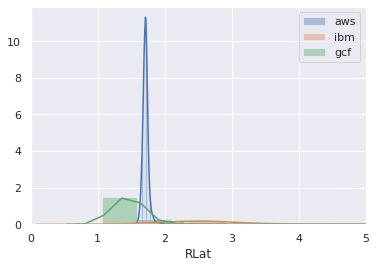

In [16]:
lat = "RLat"
for provider  in ["aws","ibm","gcf"]:
    d = paperDataSet(all_old,[provider],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])
    sns.distplot(d[d["RFailed"] == False][lat],label=provider)

plt.legend()
plt.xlim([0,5])

#### Oringial Data per Workload for AWS,GCF,IBM 

In [17]:
p_old,r_old,c_old = createMetrics(all_old,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1],["Provider","WL"],True)
#Failiur Global
pd.options.display.float_format = "{:,.4f}".format
pd.concat([r_old,p_old,c_old],axis=1)

Requests                         RLat [s]                  \
                  Send [\#] Failed [\#] Failed [\%]     Mean    90-p    99-p   
Provider Workload                                                              
AWS      WL0           6333           0      0.0000   1.7174  1.7590  1.9720   
         WL1          12708           0      0.0000   1.7166  1.7600  1.9450   
         WL3          24779           0      0.0000   1.7220  1.7660  1.9320   
         WL4          31147        2642      0.0848   1.7156  1.7670  1.8680   
GCF      WL0           6321           0      0.0000   1.9115  2.6030 10.5640   
         WL1          10992         873      0.0794   2.9273  8.1466 15.9651   
         WL3          24760           0      0.0000   1.6835  1.7270  7.7898   
         WL4          31155        2610      0.0838   1.4607  1.6210  2.2740   
ICF      WL0           6330           0      0.0000   2.4276  3.0141  3.7573   
         WL1          12727           1      0.0001   2.5993  3.2590  4.5717   
         WL3          24750           0      0.0000   8.7822 11.2202 15.7380   
         WL4          31199          21      0.0007   9.1327 11.9890 17.3391   

                                 ELat [s]                               \
                      Max    Med     Mean   90-p   99-p     Max    Med   
Provider Workload                                                        
AWS      WL0       2.4710 1.7110   1.6343 1.6720 1.8627  2.3930 1.6310   
         WL1       2.3820 1.7120   1.6386 1.6790 1.8520  2.0290 1.6370   
         WL3       2.3800 1.7160   1.6438 1.6820 1.8480  1.9720 1.6410   
         WL4       2.4100 1.7120   1.6404 1.6850 1.7840  2.0440 1.6380   
GCF      WL0      15.8850 1.4890   1.3267 1.5130 1.6928  2.4060 1.3700   
         WL1      27.3030 1.5120   1.3224 1.5000 1.6458  1.8760 1.3380   
         WL3      19.1460 1.5090   1.3736 1.5210 1.8080  2.1990 1.4050   
         WL4       4.4360 1.4850   1.3347 1.4970 1.7276  2.2670 1.3820   
ICF      WL0      17.8890 2.4320   2.0681 2.6280 3.2900  4.2870 2.0940   
         WL1       8.5980 2.5390   2.2276 2.8440 3.7363  5.9650 2.2030   
         WL3      28.4710 8.6430   4.1932 5.5950 7.4775 11.1280 4.1240   
         WL4      29.8980 8.7970   4.2878 5.7853 8.1727 15.5520 4.1620   

                  ECost [$\mu\$$]  
                             Mean  
Provider Workload                  
AWS      WL0              26.5243  
         WL1              26.5543  
         WL3              26.6404  
         WL4              26.5909  
GCF      WL0              21.1462  
         WL1              21.0897  
         WL3              21.9201  
         WL4              21.2860  
ICF      WL0              34.3207  
         WL1              37.0306  
         WL3              70.4439  
         WL4              72.0568

#### Host Usage Table for Repoduction

In [19]:
d_new = d_new[d_new["Phase"].isin(["p1","p2","p3"])]
hostview = d_new.groupby(["Provider","Phase"])[["HId","CId"]].agg(['nunique'])
#reindex(hostview)
hostview

HId     CId
               nunique nunique
Provider Phase                
aws      p1        434     434
         p2        553     553
gcf      p1        135     637
         p2        231     808
ibm      p1         44     968
         p2         50    1596

#### MAF Reroduction Table Aggregated per Worload

In [25]:
d_maf = paperDataSet(all_new_maf,["azure"],["5,5,0","15,15,0"],[1])
d_maf.loc[d_maf["RLat"] > 30,"RFailed"] = True
p_maf,r_maf,c_maf = metcisFromData(d_maf)#,group_key=["Provider"])
pd.concat([r_maf,p_maf,c_maf],axis=1)


Requests                         RLat [s]                  \
                  Send [\#] Failed [\#] Failed [\%]     Mean    90-p    99-p   
Provider Workload                                                              
MAF      WL7           4574        1697      0.3710  14.2807 25.9802 29.4480   
         WL6           1505          76      0.0505   6.0447 11.8940 23.2934   

                          ELat [s]                       ECost [$\mu\$$]  
                      Max     Mean   90-p   99-p     Max            Mean  
Provider Workload                                                         
MAF      WL7      29.9960   3.0288 3.5770 4.5389 28.7610         47.7008  
         WL6      29.6650   2.9731 3.5762 4.2546  6.4750         46.8085

#### MAF Repduction Aggregated

In [24]:
p_maf,r_maf,c_maf = metcisFromData(d_maf,group_key=["Provider"])
pd.concat([r_maf,p_maf,c_maf],axis=1)

Requests                         RLat [s]                          \
         Send [\#] Failed [\#] Failed [\%]     Mean    90-p    99-p     Max   
Provider                                                                      
MAF           6079        1773      0.2917  11.5475 24.4645 29.3246 29.9960   

         ELat [s]                       ECost [$\mu\$$]  
             Mean   90-p   99-p     Max            Mean  
Provider                                                 
MAF        3.0103 3.5770 4.4991 28.7610          4.7405

In [ ]:
d_maf = d_maf[d_maf["Phase"].isin(["p1","p2","p3"])]
d_maf.groupby(["Provider","WL","Phase"])[["HId","CIdOld"]].agg(['nunique'])